In [1]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import shap
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from collections import defaultdict

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, f1_score, make_scorer, RocCurveDisplay
from itertools import combinations

def precision_class_0(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[0]

def precision_class_1(y_true, y_pred):
    return precision_score(y_true, y_pred, average=None)[1]

def recall_class_0(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[0]

def recall_class_1(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[1]

import warnings

7033aa132a2e31989f4d19b022da42a30bb28bcea09f6282

In [2]:
os.getcwd()

'c:\\Users\\samue\\OneDrive\\Documenti\\Studio\\Università\\Tesi\\Progetto\\Ricerca\\Script\\Microarray_Script\\DatasetFull'

In [3]:
os.chdir("../../../SYMBOL/Results/DatasetFull")
# os.chdir("../store/DatasetFull")

<h2>Dataset Upload</h2>

Features

In [4]:
dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombat_symbol.csv')
print(list(dataset.columns)[2:])

['TRAK2', 'MARCHF5', 'AVIL', 'CLSTN1', 'TAPBPL', 'TRIM38', 'GDF11', 'TBXA2R', 'SPAST', 'MCM3', 'OSBP', 'SLC50A1', 'USP1', 'ZNF222', 'ATG3', 'ZFPL1', 'ERP44', 'HAPSTR1', 'TMSB15B', 'EHMT1', 'BPI', 'ABHD4', 'ADRA2A', 'UBB', 'SDHAF3', 'LPCAT3', 'CSTF2T', 'IFIH1', 'ANAPC1', 'FCER2', 'CEP192', 'TULP4', 'LFNG', 'MAP3K4', 'KLF7', 'TJP2', 'PLAG1', 'CD2', 'ICOSLG', 'TBL2', 'JHY', 'BCAS2', 'FBXL5', 'EMC2', 'ELK4', 'MCTP2', 'ABCF3', 'TRIM26', 'HNRNPK', 'XPC', 'CCDC6', 'CCDC85B', 'HBD', 'AP3B1', 'AASDHPPT', 'NFKBIA', 'ATP6V0B', 'PTOV1', 'OSBPL10', 'SLC25A42', 'HAGH', 'C2orf42', 'NDUFA3', 'NECTIN2', 'ZBTB17', 'NOCT', 'TGFBRAP1', 'TMEM115', 'BLVRA', 'LAX1', 'IL15', 'KARS1', 'FKBP2', 'GAS7', 'INPPL1', 'PIP5K1B', 'TBKBP1', 'NDUFAF7', 'GCLC', 'PRSS23', 'CD248', 'PTDSS2', 'EFHD2', 'PLA2G4C', 'IL13RA1', 'ADGRL1', 'FHOD1', 'MRPL22', 'MAF', 'COASY', 'ZNF580', 'YARS2', 'RAB14', 'EMC10', 'PTBP1', 'RXRA', 'RPRD1A', 'ARPC4', 'AAMP', 'MAPK4', 'UTP6', 'ANKRD53', 'AMZ2', 'STK39', 'PTPN11', 'OPN3', 'ZNF701', 'ABCC

In [5]:
dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombatDeclustered_symbol.csv')
label = dataset['Label']
dataset.drop(columns=['SampleID', 'PatientID', 'Label'], inplace=True)
dataset

TRAK2   MARCHF5      AVIL    CLSTN1    TAPBPL     TRIM38     GDF11  \
0     9.597071  6.172613  6.183003  7.619254  8.451946   9.674435  6.629841   
1     9.039251  6.532620  6.350718  7.841904  8.629886   9.565077  6.824635   
2     8.791386  6.548371  6.933703  7.279164  8.166420   9.772884  6.515736   
3     9.373170  7.116801  7.012218  7.233344  8.338171   9.725869  6.458866   
4     9.076237  7.104757  6.515409  7.488312  8.355218  10.033820  6.189225   
...        ...       ...       ...       ...       ...        ...       ...   
1033  8.955028  6.642111  6.639887  7.445428  8.359939   9.682368  6.735513   
1034  9.101329  6.715089  6.611748  7.449074  8.112262   9.634445  6.503292   
1035  9.271382  6.670915  6.620238  7.404586  8.119619   9.650254  6.681918   
1036  9.351712  6.679360  6.581669  7.442222  8.282929   9.638524  6.409742   
1037  9.292476  6.678637  6.662260  7.397570  8.343229   9.653412  6.024943   

        TBXA2R     SPAST      MCM3  ...   PAK1IP1     NDUFA1      PEX7  \
0     6.700156  7.881287  8.240517  ...  7.339375  10.188925  6.535162   
1     6.727150  7.830775  8.208113  ...  7.251840  10.255465  6.432247   
2     6.363606  7.827843  8.133049  ...  7.279236  10.101372  6.495679   
3     6.108414  8.426698  8.078382  ...  7.311252  10.314306  6.353293   
4     6.473050  8.245104  8.216184  ...  7.289160  10.243407  6.334131   
...        ...       ...       ...  ...       ...        ...       ...   
1033  6.554890  8.052685  8.162122  ...  7.015461  10.312671  5.698647   
1034  6.350074  8.274160  8.296960  ...  7.259678  10.357670  6.671623   
1035  6.342317  8.287929  8.152867  ...  7.351145  10.208762  6.715863   
1036  6.433034  8.261687  8.273441  ...  7.178289  10.401224  6.861365   
1037  6.410587  8.050168  8.169079  ...  7.309705  10.255236  6.813299   

          NET1     TMED5      FADD     URGCP      MDM4    BMPR1A    EIF1AY  
0     7.816546  9.744325  8.263995  7.352167  8.662674  6.263145  5.084750  
1     7.916046  9.687447  8.241698  7.349809  8.445578  7.242537  5.046855  
2     8.104559  9.632676  8.242744  7.205897  8.071700  6.124447  5.049761  
3     7.386301  9.769748  8.376067  7.312015  8.425182  6.534315  5.051708  
4     7.331289  9.626407  8.217957  7.254979  7.917974  6.195773  5.038392  
...        ...       ...       ...       ...       ...       ...       ...  
1033  7.380776  9.698418  8.155223  7.361099  8.327890  6.361955  5.504788  
1034  7.428976  9.763741  8.122246  7.262578  8.175908  7.282642  5.622606  
1035  7.705067  9.785031  8.103883  7.362873  8.131763  7.425195  5.609163  
1036  7.413546  9.703183  8.135620  7.244212  8.187447  6.908857  5.568584  
1037  7.595989  9.750070  8.454906  7.257439  8.178654  6.913615  5.572668  

[1038 rows x 6668 columns]

<h3>Scaling</h3>

In [31]:
gradientBoosting = joblib.load("xgbDefFull.pkl")

current = dataset.copy()
current_Scaled = gradientBoosting[0].transform(current)
current_Scaled = pd.DataFrame(current_Scaled, columns=current.columns)
current_Scaled.insert(0, 'Label', label)

n = int(current_Scaled.shape[0] * 0.1)

print(n)

noMS = current_Scaled[current_Scaled['Label'] == 0].sample(n, random_state=42)
ms = current_Scaled[current_Scaled['Label'] == 1].sample(n, random_state=42)

currentBack = pd.concat([noMS, ms]).sample(frac=1, random_state=42).reset_index(drop=True)

currentBack.drop(columns=['Label'], inplace=True)
current_Scaled.drop(columns=['Label'], inplace=True)

103


<h2> SHAP Explanations</h3>

In [32]:
explainer = shap.TreeExplainer(gradientBoosting[-1], currentBack)
shap_object = explainer(current_Scaled)

shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(gradientBoosting.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))

expl_sorted

 95%|=================== | 986/1038 [00:14<00:00]       

{'ABCA1': 0.42377776283466634,
 'NDUFS5': 0.3599050004923352,
 'HLA-DRB1': 0.28484796561932874,
 'CROCC': 0.23561278175067588,
 'HLA-DRB5': 0.23398413513076485,
 'KLF3-AS1': 0.21342996862072747,
 'SPATA7': 0.21138137835470483,
 'EIF2S2': 0.2109245362167198,
 'MRFAP1L1': 0.20882398229173116,
 'DNAAF11': 0.1861498099477038,
 'MAMLD1': 0.18546270353927777,
 'FOXRED2': 0.18288684168858338,
 'LILRA2': 0.18088312908868937,
 'MUC1': 0.175282587143296,
 'SFSWAP': 0.17320766953981148,
 'CTSG': 0.17203436551048554,
 'SRSF11': 0.16574600106839119,
 'SPATA2': 0.15846233858609407,
 'CD163': 0.15371651670143674,
 'GPR68': 0.14969893733267378,
 'PPP2R1A': 0.14723453337029657,
 'ADAT1': 0.1454765385455316,
 'SEC14L1': 0.1448585185989097,
 'HDC': 0.14472861849621266,
 'CRTAP': 0.14271759805736073,
 'FKBP5': 0.14221343024269112,
 'ZNF473': 0.14084543384486664,
 'NOL11': 0.1407972638809925,
 'ERICH1': 0.14041240065139654,
 'TMX4': 0.13291124768151383,
 'RFTN1': 0.1289153791200694,
 'TMT1A': 0.12445545419

In [4]:
# def addGeneClusters(geneDict):
#     clusters = joblib.load("uniqueClustersFull.pkl")

#     resultValues = list(geneDict.values())
#     resultKeys = list(geneDict.keys())

#     for key, gene in clusters.items():
#         print(gene, gene in resultKeys)
        
#         if gene in resultKeys:
#             insertGenes = [k for k in key if k != gene]
#             idx = resultKeys.index(gene)
#             resultValues[idx+1:idx+1] = [resultValues[idx]] * len(insertGenes)
#             resultKeys[idx+1:idx+1] = insertGenes

#             print(gene, resultValues[idx], insertGenes, [resultValues[idx]] * len(insertGenes))

#     return dict(zip(resultKeys, resultValues))

def addGeneClusters(geneDict, clusters):
    clusters = inverDict(clusters)
    resultValues = list(geneDict.values())
    resultKeys = list(geneDict.keys())

    for gene, cluster in clusters.items():
        if gene in list(geneDict.keys()):
            insertGenes = list(set(cluster) - set([gene]))
            idx = resultKeys.index(gene)
            resultValues[idx+1:idx+1] = [resultValues[idx]] * len(insertGenes)
            resultKeys[idx+1:idx+1] = insertGenes

    return dict(zip(resultKeys, resultValues))

def inverDict(d):
    inverted = defaultdict(list)

    for keys_tuple, value in d.items():
        inverted[value].extend(list(keys_tuple))

    return dict(inverted)

shap_object = joblib.load("xgbDefFull_shapValues.pkl")
expl_sorted = joblib.load("xgbDefFull_explSorted.pkl")
feature_nonZero = {k:v for k, v in expl_sorted.items() if v != 0}

Features with non-zero importance

In [7]:
print(list(feature_nonZero.keys()))

['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FAAH', 'PLLP', 'GNLY', 'PANK4', 'LPCAT3', 'ZNF80', 'KIAA0408', 'SDK2', 'CHAF1A', 'FEZ1', 'IL32', 'EIF2AK2', 'RBM4', 'C

<h2>Explorative Graphs</h2>

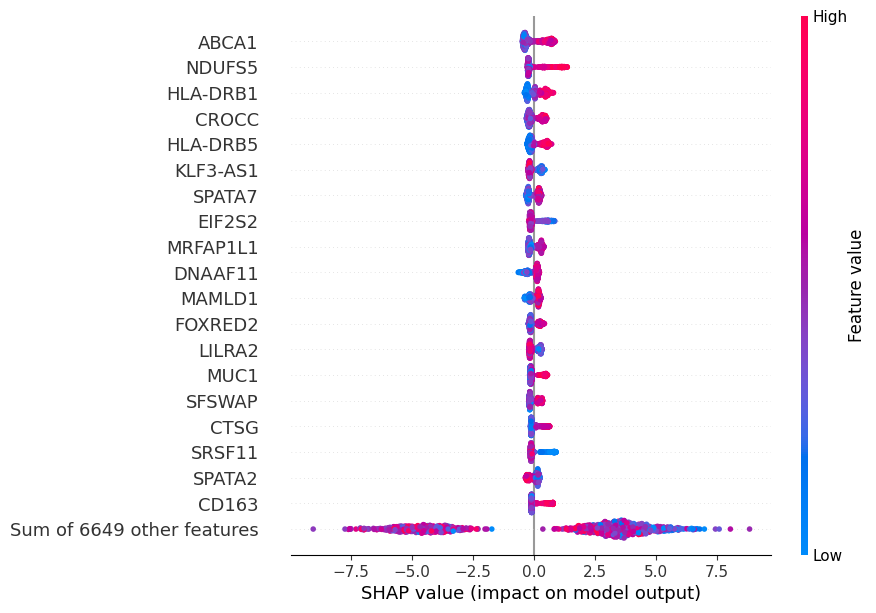

In [ ]:
plt.close()
fig, ax = plt.subplots()
shap.plots.beeswarm(shap_object, max_display=20, plot_size=(10, 7), show=False)
fig.subplots_adjust(left=0.3)

Text(0.5, 1.0, 'Top 25 features for importance')

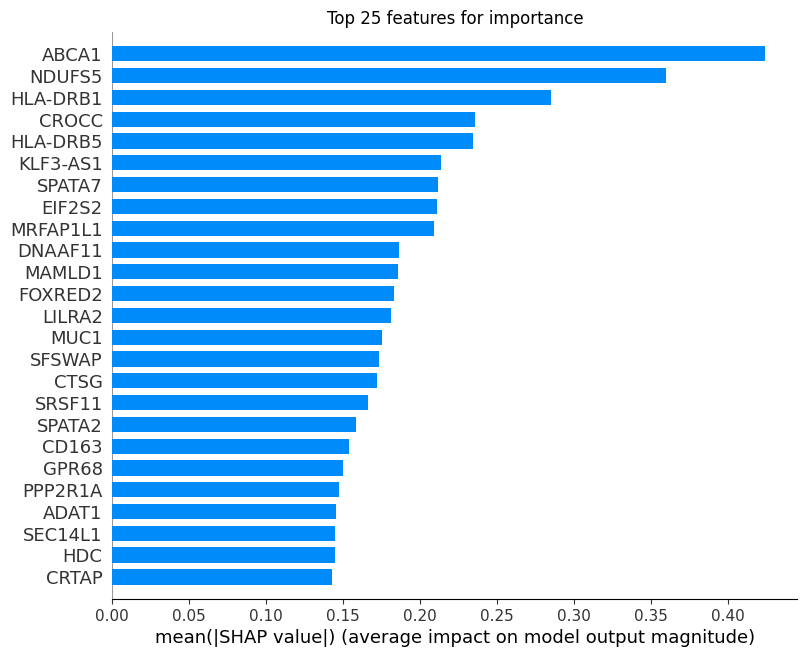

In [8]:
plt.close()
fig, ax = plt.subplots()
shap.summary_plot(shap_object, current_Scaled, max_display=25, plot_type="bar", show=False, plot_size=(10, 7))
fig.subplots_adjust(left=0.3, top=0.9)
plt.title('Top 25 features for importance')

In [19]:
cont = 0
for value in expl_sorted.values():
      if value != 0:
        cont+=1

print('Feature con importanza non zero:', cont)

Feature con importanza non zero: 724


<h3>Distribution of feature importances</h3>

Mean: 0.030925875462513325
Stadnard Deviation: 0.04246750068373472
Number of features of 0 sigma: 205 ['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FAAH', 'PLLP', '

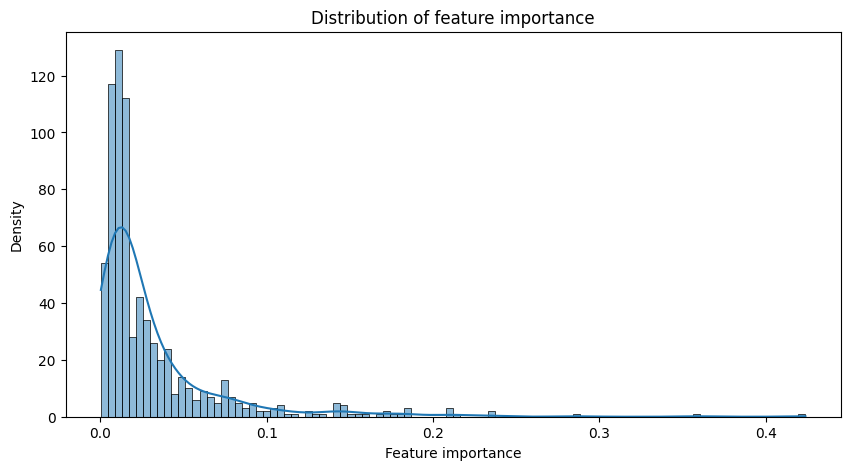

In [20]:
non_zeroShap = [value for value in expl_sorted.values() if value != 0]
mean = np.mean(non_zeroShap)
std = np.std(non_zeroShap)

print('Mean:', mean)
print('Stadnard Deviation:', std)
k=0
bestFeatures = [key for key, value in expl_sorted.items() if value > (k*std)+mean]
print(f"Number of features of {k} sigma:", len(bestFeatures), bestFeatures)

plt.close()
plt.figure(figsize=(10,5))
sns.histplot(data=non_zeroShap, bins=100, kde=True)
plt.title('Distribution of feature importance')
plt.xlabel('Feature importance')
plt.ylabel('Density')
plt.show()

<h3>Cumulative Importance</h3>

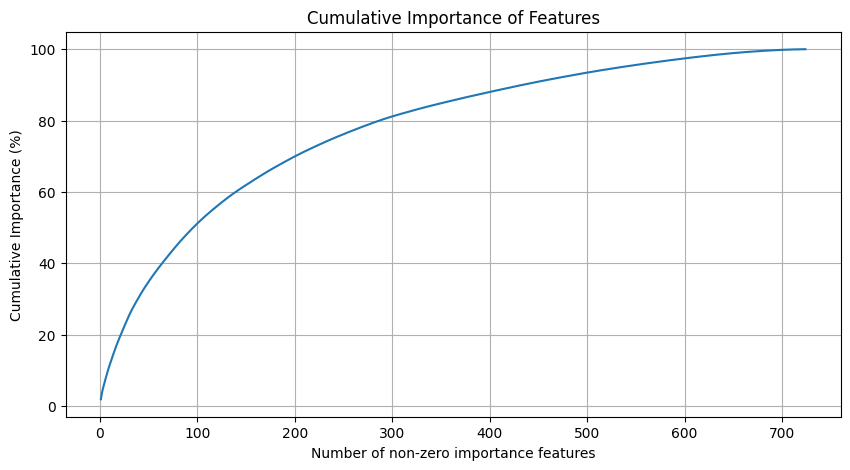

In [25]:
cumulativeImportance = (np.array(list(feature_nonZero.values())).cumsum() / np.array(list(feature_nonZero.values())).sum()) * 100

plt.close()
plt.figure(figsize=(10,5))
plt.plot(range(1, len(cumulativeImportance)+1), cumulativeImportance)
plt.xlabel('Number of non-zero importance features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Importance of Features')
plt.grid()
plt.show()

In [26]:
print(list(feature_nonZero.keys())[:300])

['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FAAH', 'PLLP', 'GNLY', 'PANK4', 'LPCAT3', 'ZNF80', 'KIAA0408', 'SDK2', 'CHAF1A', 'FEZ1', 'IL32', 'EIF2AK2', 'RBM4', 'C

<h3>Bar plot of importances over the two classes</h3>

In [33]:
current = current_Scaled.copy()
current.insert(0, 'Label', label)


cohorts = ["MS" if label == 1 else "Control" for label in current['Label']]
cohort_explanation = shap_object.cohorts(cohorts)
cohort_means = cohort_explanation.abs.mean(0)

cohort_df = pd.DataFrame({
    'MS': cohort_explanation.cohorts['MS'].values.mean(0),
    'Control': cohort_explanation.cohorts['Control'].values.mean(0)
}, index=current_Scaled.columns) 

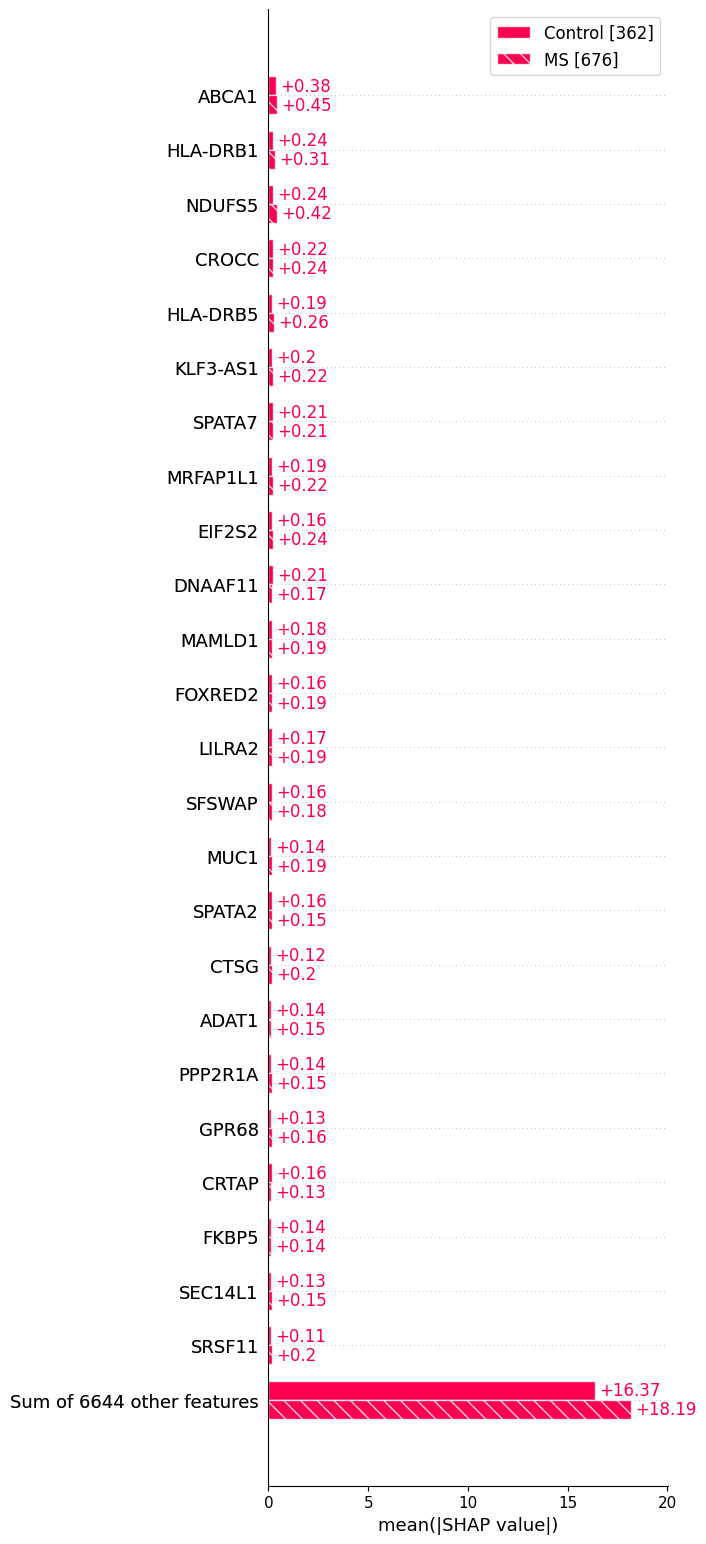

In [34]:
plt.close()
fig, ax = plt.subplots(figsize=(10, 5))
shap.plots.bar(cohort_means, max_display=25, show=False)
fig.subplots_adjust(left=0.4)

Showing the genes where the importance for the class MS is higher than a value epsilon compared to the importance of the Control class

In [35]:
diff = np.abs(cohort_df['MS'] - cohort_df['Control'])

Difference importance between classes distribution

In [36]:
diff_mean = np.mean(diff)
diff_meadian = np.median(diff)
diff_std = np.std(diff)

print('Mean:', diff_mean)
print('Median:', diff_meadian)
print('Stadnard Deviation:', diff_std)
k=0
bestFeatures = [key for key, value in expl_sorted.items() if value > (k*diff_std)+diff_mean]
print(f"Number of features over {k} sigma:", len(bestFeatures), bestFeatures)

Mean: 0.0015801895843965818
Median: 0.0
Stadnard Deviation: 0.0093722805111605
Number of features over 0 sigma: 715 ['ABCA1', 'NDUFS5', 'HLA-DRB1', 'CROCC', 'HLA-DRB5', 'KLF3-AS1', 'SPATA7', 'EIF2S2', 'MRFAP1L1', 'DNAAF11', 'MAMLD1', 'FOXRED2', 'LILRA2', 'MUC1', 'SFSWAP', 'CTSG', 'SRSF11', 'SPATA2', 'CD163', 'GPR68', 'PPP2R1A', 'ADAT1', 'SEC14L1', 'HDC', 'CRTAP', 'FKBP5', 'ZNF473', 'NOL11', 'ERICH1', 'TMX4', 'RFTN1', 'TMT1A', 'ING2', 'HUWE1', 'OSBPL1A', 'FANCL', 'CDC42', 'SIAH1', 'RCC1', 'FUZ', 'ZNF432', 'DBN1', 'HBD', 'ACO2', 'EIF4G1', 'TAF6', 'GORASP1', 'FGGY', 'SPART', 'BCAS4', 'CD151', 'ZBTB5', 'COX20', 'COX14', 'DEDD', 'LRP1', 'SSTR2', 'SLC35B1', 'MARCHF6', 'PPP2R5D', 'RMC1', 'AP1S1', 'CSNK2A2', 'RRP7A', 'EIF3A', 'TIMM10', 'DUSP2', 'ABCC5', 'CLN8', 'DYNC1LI2', 'EPHA1', 'TCEAL2', 'RNF146', 'ZC3HAV1', 'NDUFA5', 'H2BC21', 'FARSA', 'LAPTM4B', 'NADK', 'EPHB1', 'TM9SF1', 'EHD1', 'POLD3', 'DDIT4', 'GALNT6', 'PFKP', 'DNAJA3', 'MT1F', 'RNF24', 'EIF3H', 'FAF2', 'QSOX1', 'RBMS2', 'PLK4', 'FA

Test for difference of importance between classes

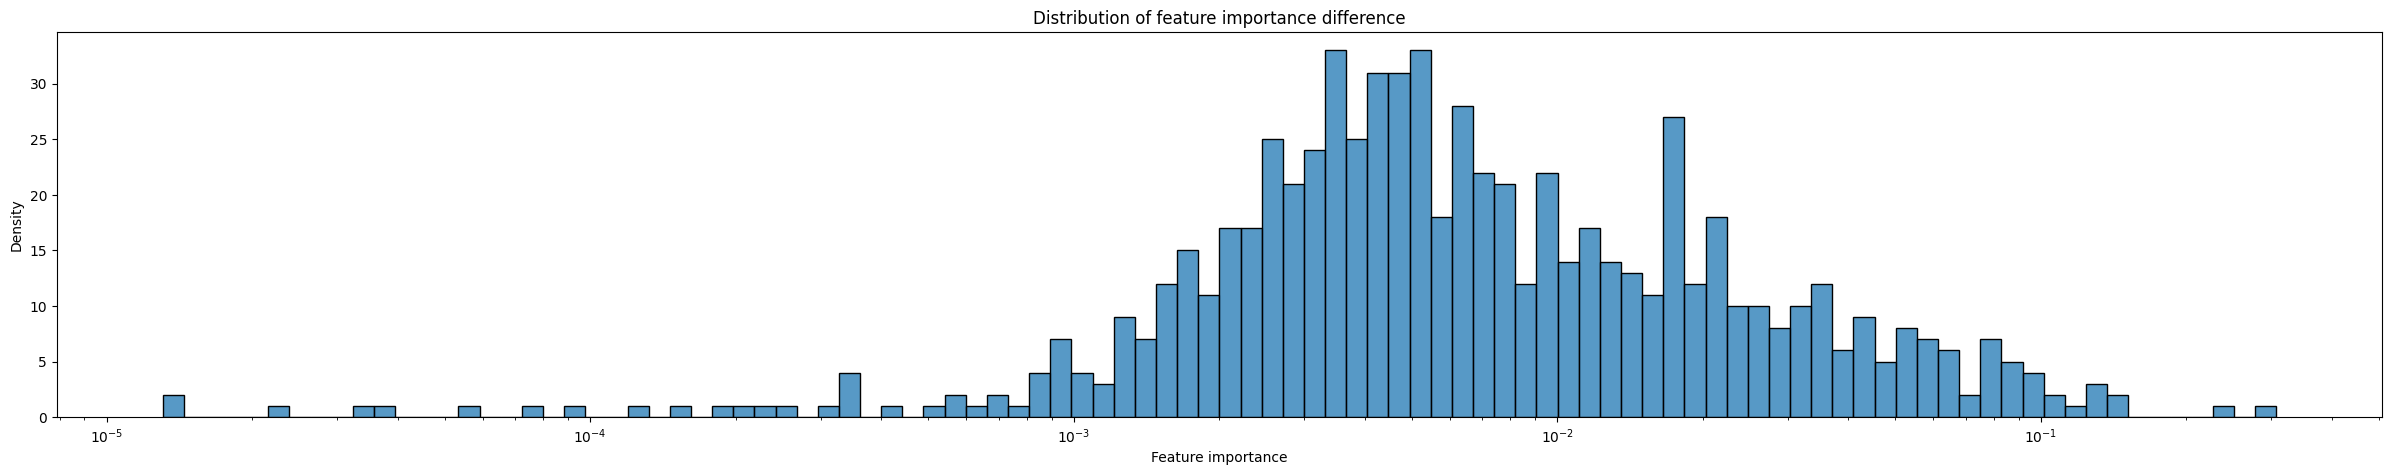

In [37]:
plt.close()
plt.figure(figsize=(30,5))
sns.histplot(data=diff, bins=100, log_scale=True)
plt.title('Distribution of feature importance difference')
plt.xlabel('Feature importance')
plt.ylabel('Density')
plt.show()

In [39]:
epsilon = 0.01  # Modifica questo valore
significant_features = diff[diff >= epsilon].index.tolist()

print(f"Feature con differenza >= {epsilon}:")
print(len(significant_features), significant_features)

Feature con differenza >= 0.01:
245 ['LPCAT3', 'HBD', 'PPP2R5D', 'HEATR6', 'BTRC', 'POLD3', 'QSOX1', 'GORASP1', 'PATJ', 'RBMS2', 'PPP3R1', 'CTSG', 'FAAH', 'AQP3', 'CTSK', 'H2AC8', 'CDKN1B', 'NREP', 'CRTAP', 'TIMM10', 'GARS1', 'TBC1D9B', 'MRFAP1L1', 'P4HA1', 'TMX4', 'RMC1', 'MARCHF6', 'STRN', 'ABCA1', 'RPL14', 'EIF3A', 'ITK', 'FGGY', 'BID', 'MICU1', 'BORA', 'FARSA', 'GBP2', 'LILRA3', 'GNAI3', 'HADHA', 'CACNA2D2', 'ERICH1', 'KLF3-AS1', 'LAPTM4B', 'SRSF11', 'ADAT1', 'TXNRD1', 'RAPGEF1', 'TIMM13', 'GPR68', 'PANK4', 'EIF2AK2', 'ZNF432', 'FAF2', 'CD163', 'RNF24', 'PLK4', 'RBM6', 'RCC1', 'TAF1', 'CD151', 'SPART', 'ASCC1', 'EZH1', 'CROCC', 'PPP2CB', 'LILRA2', 'ITM2C', 'APOC1', 'DYRK2', 'FTH1', 'TMEM143', 'SLC35B1', 'NMRK1', 'AHI1', 'COTL1', 'TRIM3', 'KLF4', 'EGR1', 'TM9SF1', 'PSMB9', 'ABCC5', 'LPAR6', 'NECTIN1', 'PTPN6', 'RNF146', 'LTA4H', 'ZNF143', 'FEZ1', 'KLRG1', 'KRAS', 'IK', 'NEDD8', 'P3H2', 'WWP2', 'PLLP', 'AGO2', 'MUC1', 'RFTN1', 'EHD1', 'CBR1', 'CENPB', 'MSL3', 'PMP22', 'PRR3', 'LY86',

DEA between cohorts over SHAP values

In [40]:
current = dataset.copy()

warnings.filterwarnings("ignore")

current = current_Scaled.copy()
current.insert(0, 'Label', label)


cohorts = ["MS" if label == 1 else "Control" for label in current['Label']]
cohort_explanation = shap_object.cohorts(cohorts)

cohort_ms = pd.DataFrame(cohort_explanation.cohorts['MS'].values, columns=current_Scaled.columns)
cohort_control = pd.DataFrame(cohort_explanation.cohorts['Control'].values, columns=current_Scaled.columns)

p_values = [mannwhitneyu(cohort_control[gene], cohort_ms[gene])[1] for gene in cohort_control.columns]
boolean, p_values_corrected = fdrcorrection(p_values, alpha=0.05)
deGenes = {gene:value for gene, sig, value in zip(cohort_control.columns, boolean, p_values_corrected) if sig}

print(len(deGenes), list(deGenes.keys()))

553 ['ABHD4', 'LPCAT3', 'KLF7', 'HBD', 'NFKBIA', 'TGFBRAP1', 'CD248', 'PLA2G4C', 'FHOD1', 'NAMPT', 'PPP2R5D', 'COLGALT2', 'MAST2', 'ACSS3', 'HEATR6', 'UPF3B', 'CASP8', 'MYDGF', 'BTRC', 'PBRM1', 'POLD3', 'SLC29A1', 'QSOX1', 'GORASP1', 'PATJ', 'RBMS2', 'PPP3R1', 'MTG1', 'RIPOR2', 'CTSG', 'IDH1', 'UBE2E1', 'FAAH', 'METTL3', 'CITED2', 'CAPN5', 'AQP3', 'CTSK', 'H2AC8', 'NKTR', 'RHOA', 'CXCR4', 'CDKN1B', 'TTN', 'NREP', 'CRTAP', 'CDK5RAP3', 'EWSR1', 'HEXB', 'TIMM10', 'TBC1D9B', 'ANP32CP', 'MRFAP1L1', 'P4HA1', 'TMX4', 'RMC1', 'OGFOD1', 'CUX1', 'MARCHF6', 'DHX40', 'PARK7', 'FYCO1', 'RNASET2', 'STRN', 'NCOA6', 'MYOM1', 'GFOD1', 'REEP5', 'ABCA1', 'RPL23A', 'RPL14', 'EIF3A', 'ITK', 'FGGY', 'BID', 'SMARCE1', 'NKRF', 'MICU1', 'BORA', 'KIAA0232', 'KHNYN', 'FARSA', 'PCBP1', 'DHX8', 'GBP2', 'IL1B', 'STAG2', 'GNAI3', 'HADHA', 'IGFBP6', 'CACNA2D2', 'RTL8C', 'PIGV', 'ERICH1', 'ENO1', 'KLF3-AS1', 'LAPTM4B', 'ZNF239', 'AMPD3', 'RAI14', 'CLEC10A', 'UNC93B1', 'CLEC2D', 'CD28', 'BCL11A', 'TIMM10B', 'PRKCD', 'O

In [41]:
print(len(set(significant_features).intersection(set(deGenes.keys()))), set(significant_features).intersection(set(deGenes.keys())))

227 {'FAAH', 'ZBTB5', 'TM9SF1', 'CSTB', 'FTH1', 'ADRB2', 'AGO2', 'HBD', 'FARSA', 'LY86', 'SOD1', 'SMAGP', 'CLIC3', 'EIF2AK2', 'NECTIN1', 'PLLP', 'TTI2', 'MAMLD1', 'NDUFS5', 'TCEAL2', 'PFKFB4', 'SFSWAP', 'SIRT5', 'F2RL1', 'CENPO', 'CHAF1A', 'LPAR6', 'SIAH1', 'MARCHF6', 'PPP2CB', 'H2BC21', 'ZNF80', 'ADAT1', 'HDC', 'SPART', 'FGGY', 'LILRA2', 'PFKP', 'DYRK2', 'PPP2R1A', 'GNLY', 'MUC1', 'SSTR2', 'RAB22A', 'PMP22', 'ITM2C', 'SLC35B1', 'MFN2', 'TMEM143', 'ASCC1', 'TAF1', 'AHI1', 'ZC3HAV1', 'APOC1', 'NOL11', 'CRTAP', 'MICU1', 'POLD3', 'SPATA7', 'HADHA', 'DYNC1I2', 'SYF2', 'SRSF11', 'CTSG', 'FUZ', 'GMFG', 'DNAJA3', 'MT1F', 'ATP6V1G1', 'RAPGEF1', 'BCAS4', 'KLF4', 'TMX4', 'KLF3-AS1', 'CBR1', 'GALNT6', 'ATF6', 'NREP', 'ENSA', 'VPS13C', 'PTCRA', 'ZNF432', 'RNF146', 'NDUFA5', 'P3H2', 'SPATA2L', 'NRDE2', 'FOXRED2', 'ACO2', 'PATJ', 'URM1', 'DNAAF11', 'PLK4', 'BID', 'GNAI3', 'RRP7A', 'FEZ1', 'BORA', 'RFTN1', 'ING2', 'HEATR6', 'SQOR', 'CLN8', 'DDIT4', 'TAF6', 'EZH1', 'TAPT1', 'PRR3', 'EHD1', 'CCT6B', 'L

<h3>Dependence plot with interactions for the 2 known gene of the family HLA</h3>

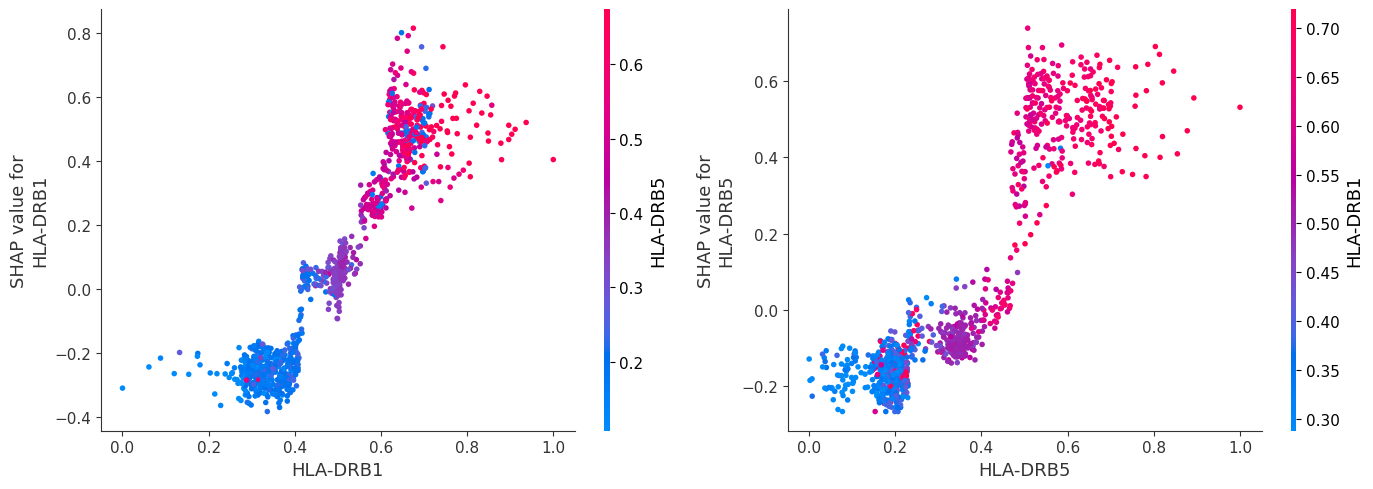

In [42]:
shap_values = shap_object.values

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
shap.dependence_plot("HLA-DRB1", shap_values, current_Scaled, show=False, interaction_index='HLA-DRB5', ax=ax[0])
shap.dependence_plot("HLA-DRB5", shap_values, current_Scaled, show=False, interaction_index='HLA-DRB1', ax=ax[1])
plt.tight_layout()

<h3>Dependence plot of the first 20 features for importance</h3>

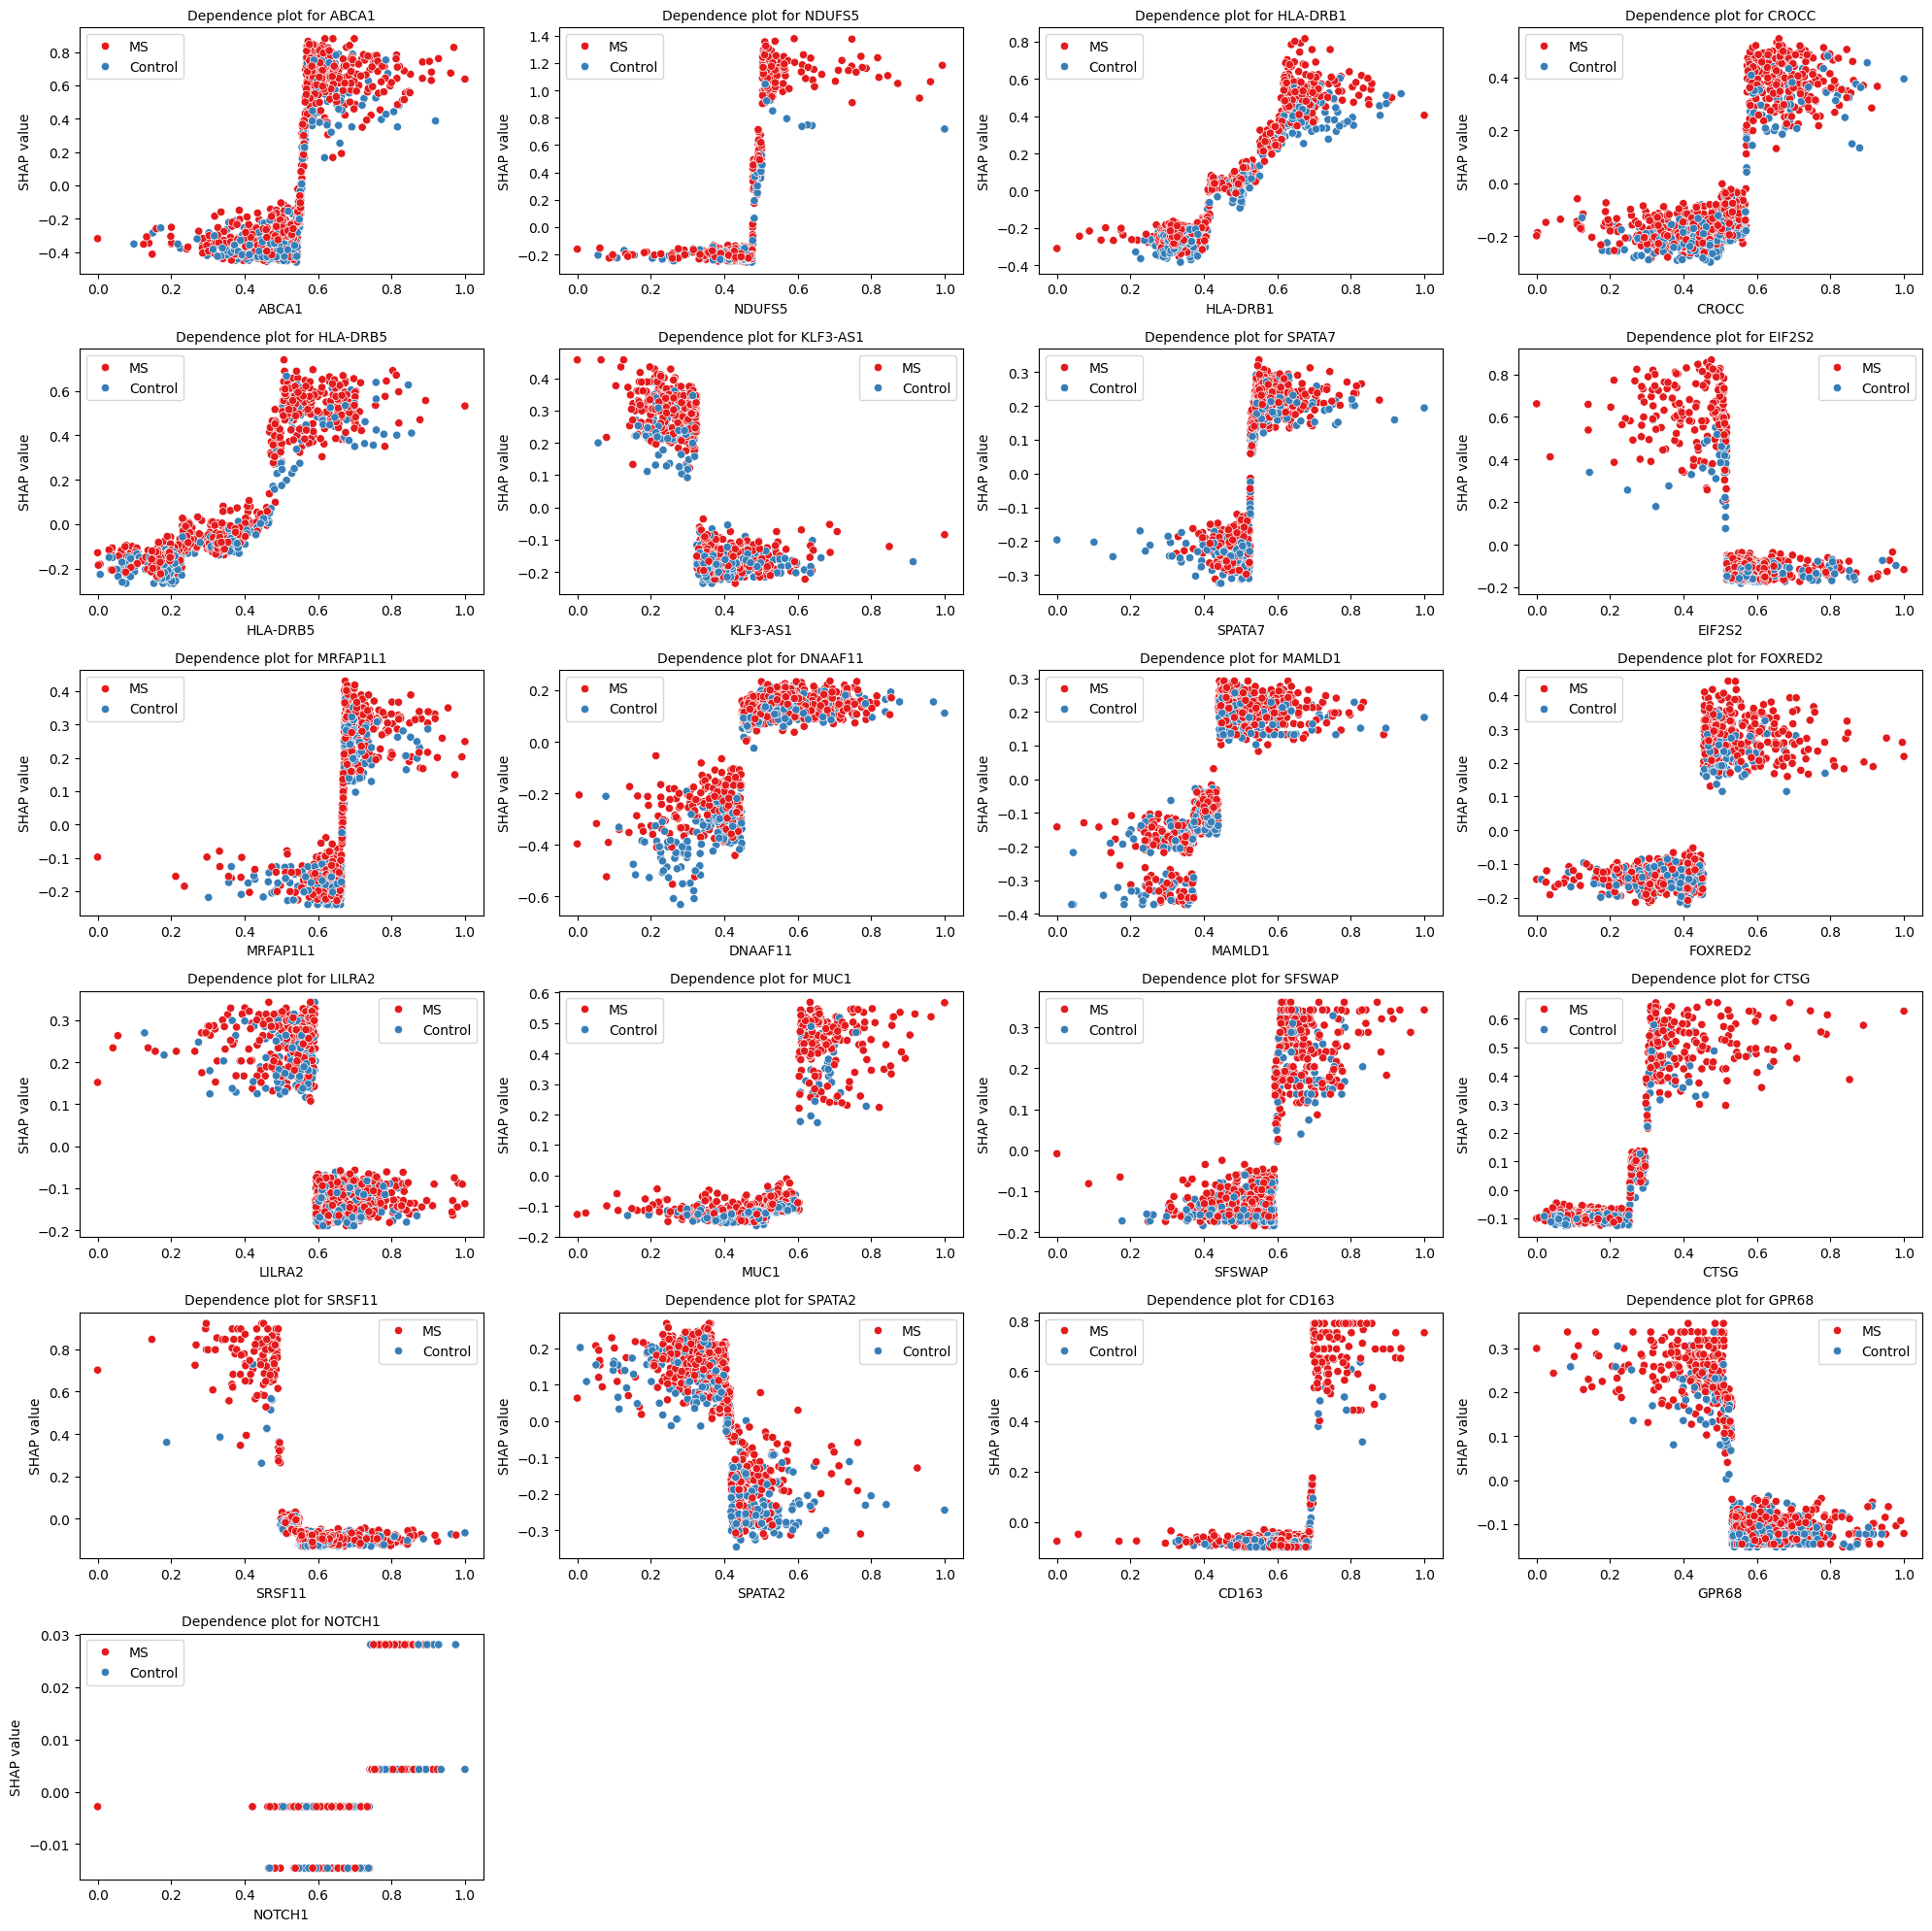

In [43]:
plt.close()

warnings.filterwarnings("ignore")

current = current_Scaled.copy()

n = 6
fig, axes = plt.subplots(n, 4, figsize=(20, 20))
axes = axes.flatten() 

featureList = list(expl_sorted.keys())[:20]
featureList.append('NOTCH1')


for i, feature in enumerate(featureList):
    if i >= len(axes):
        break

    shap_vals = shap_object.values[:, current.columns.get_loc(feature)]
    feature_vals = current[feature].values

    customDf = pd.DataFrame({
        'SHAP': shap_vals,
        'Feature': feature_vals,
        'Label': ['MS' if value == 1 else 'Control' for value in label]

    })

    sns.scatterplot(data=customDf, x='Feature', y='SHAP', hue='Label', palette='Set1', ax=axes[i])
    
    axes[i].set_title(f'Dependence plot for {feature}', fontsize=10)
    axes[i].set_xlabel(f'{feature}')
    axes[i].set_ylabel('SHAP value')
    axes[i].legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<h3>Dependence plot with interactions beetween the combination of the first 5 features for importance</h3>

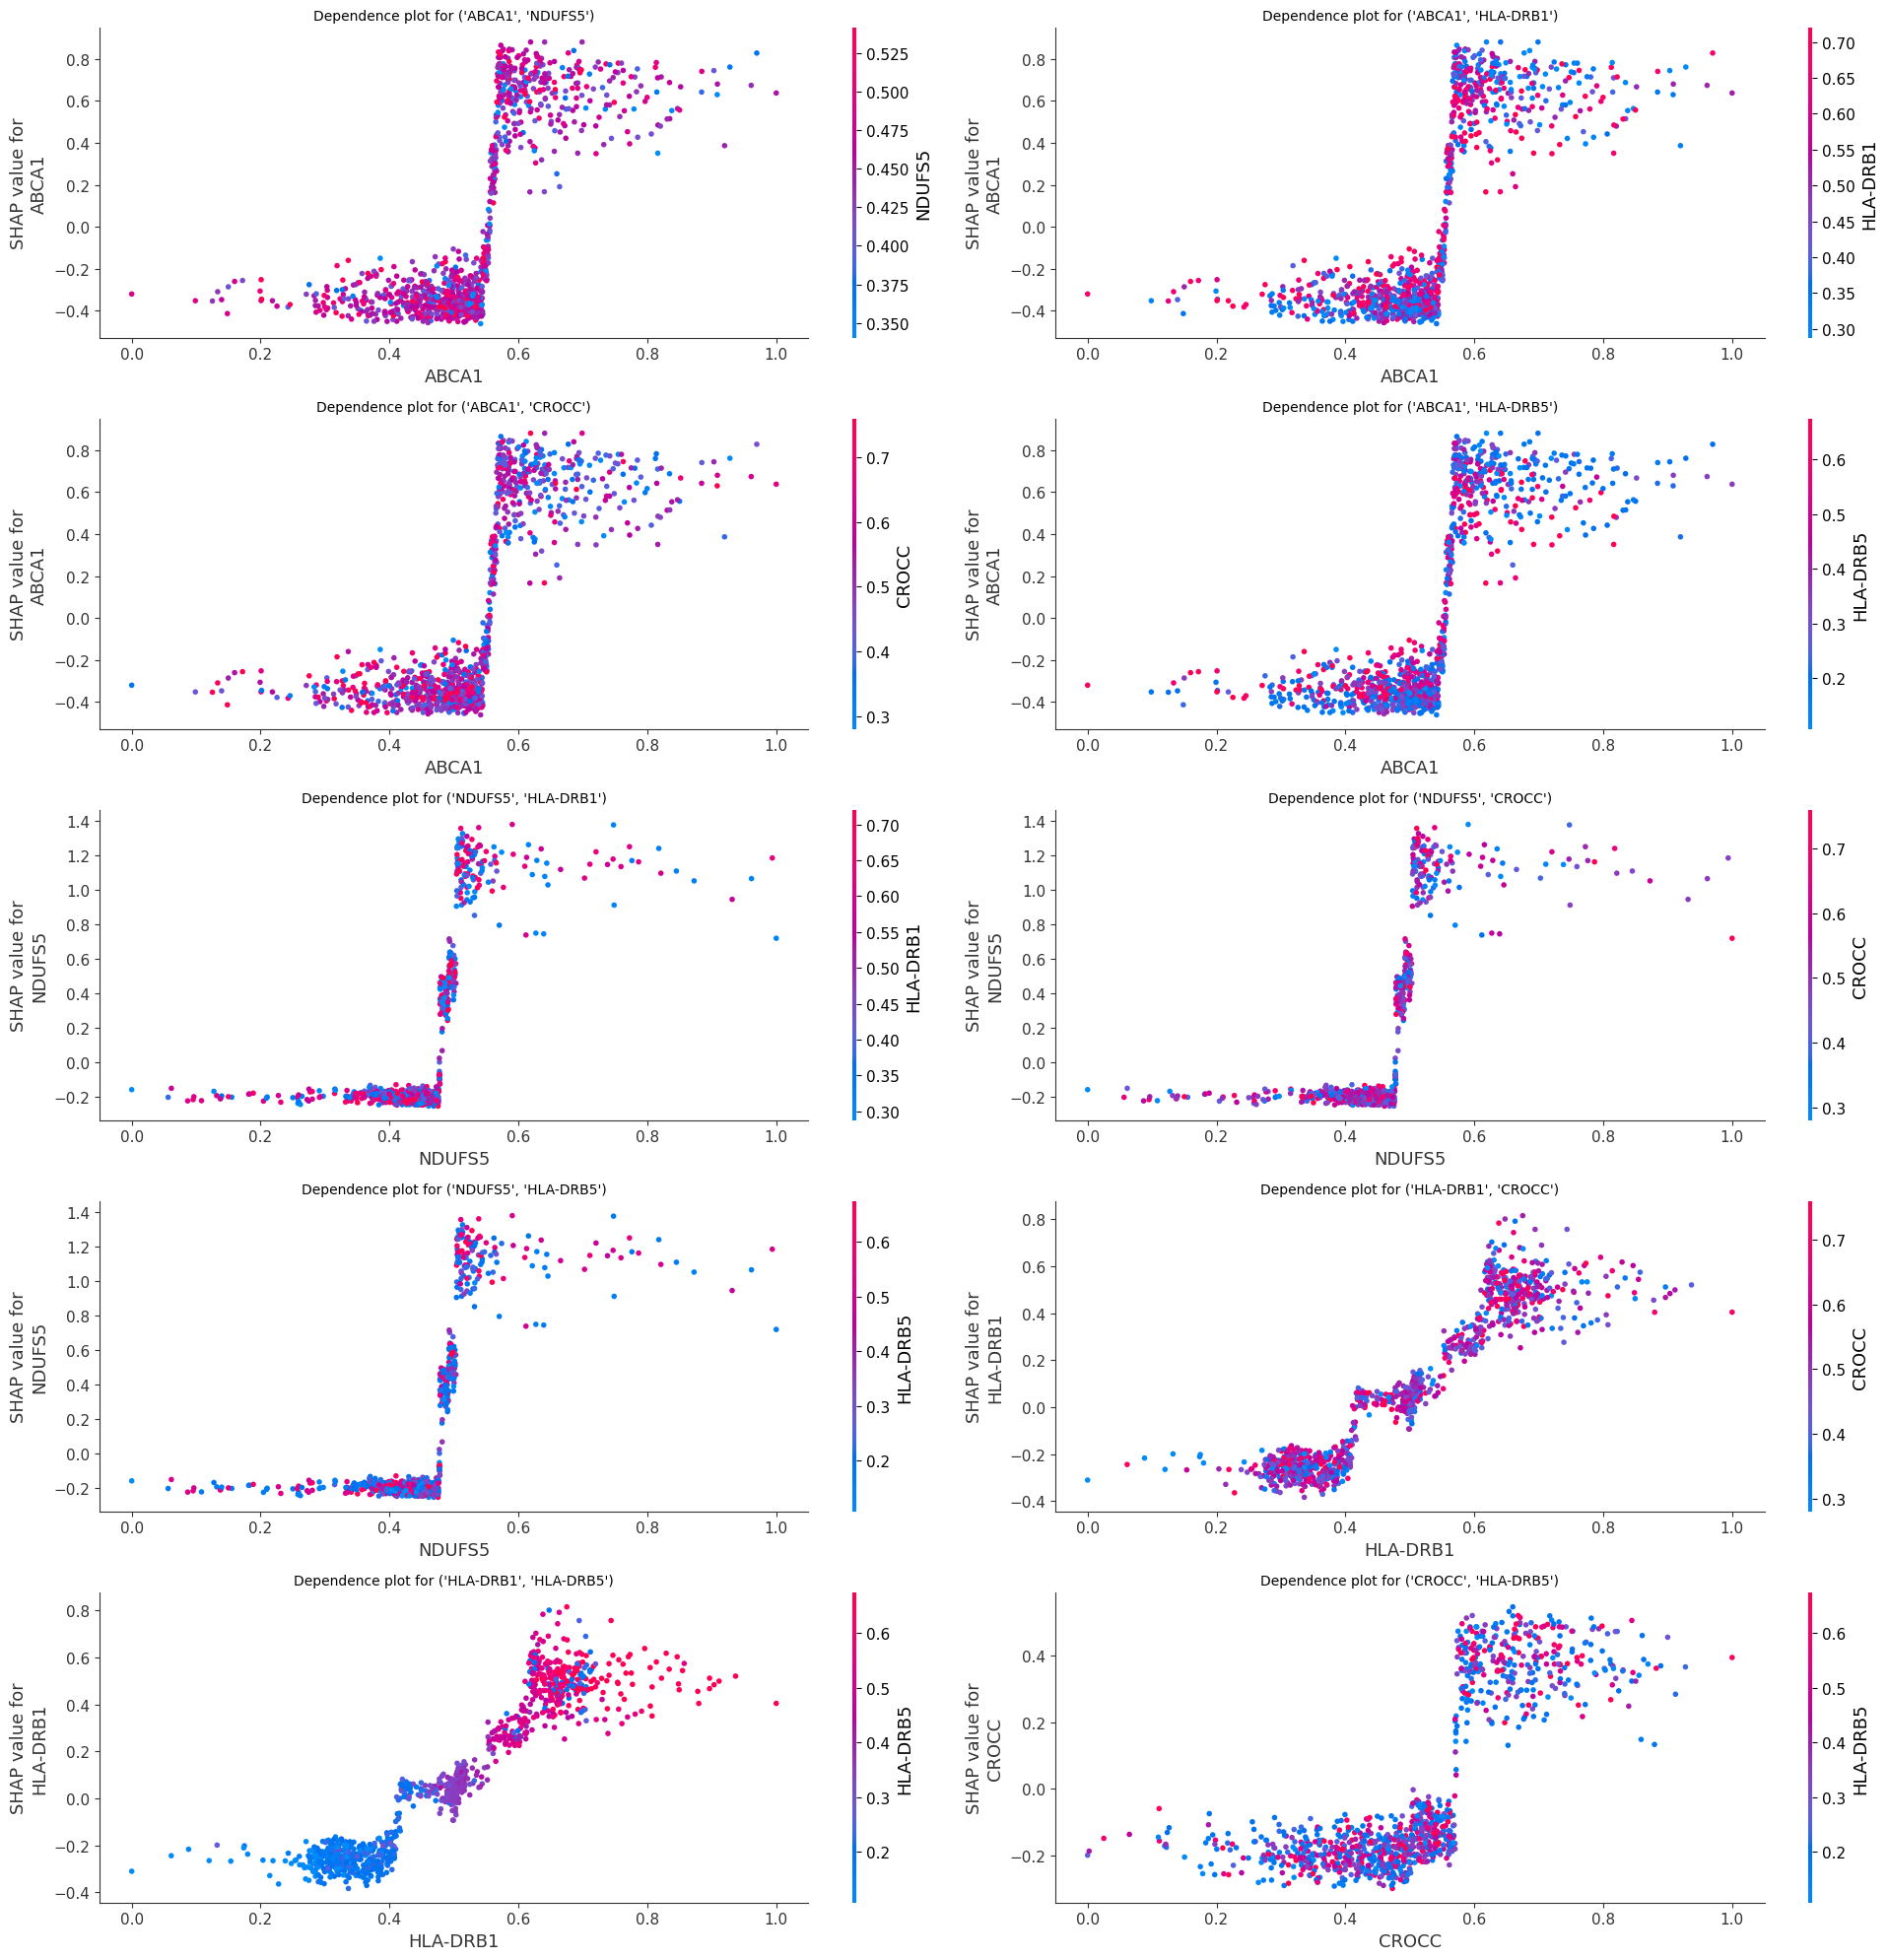

In [44]:
plt.close()

n = 5
fig, axes = plt.subplots(n, 2, figsize=(20, 20))
axes = axes.flatten()

features = list(expl_sorted.keys())[:5]
featuresCoupled = list(combinations(features, 2))

for i, feature in enumerate(featuresCoupled):
    if i >= len(axes): 
        break
    shap.dependence_plot(
        feature[0],
        shap_values,
        current_Scaled, 
        interaction_index=feature[1],
        ax=axes[i],
        alpha=1,
        show=False
    )
    
    axes[i].set_title(f'Dependence plot for {feature}', fontsize=10)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

<h3>Shap correlation between top genes</h3>

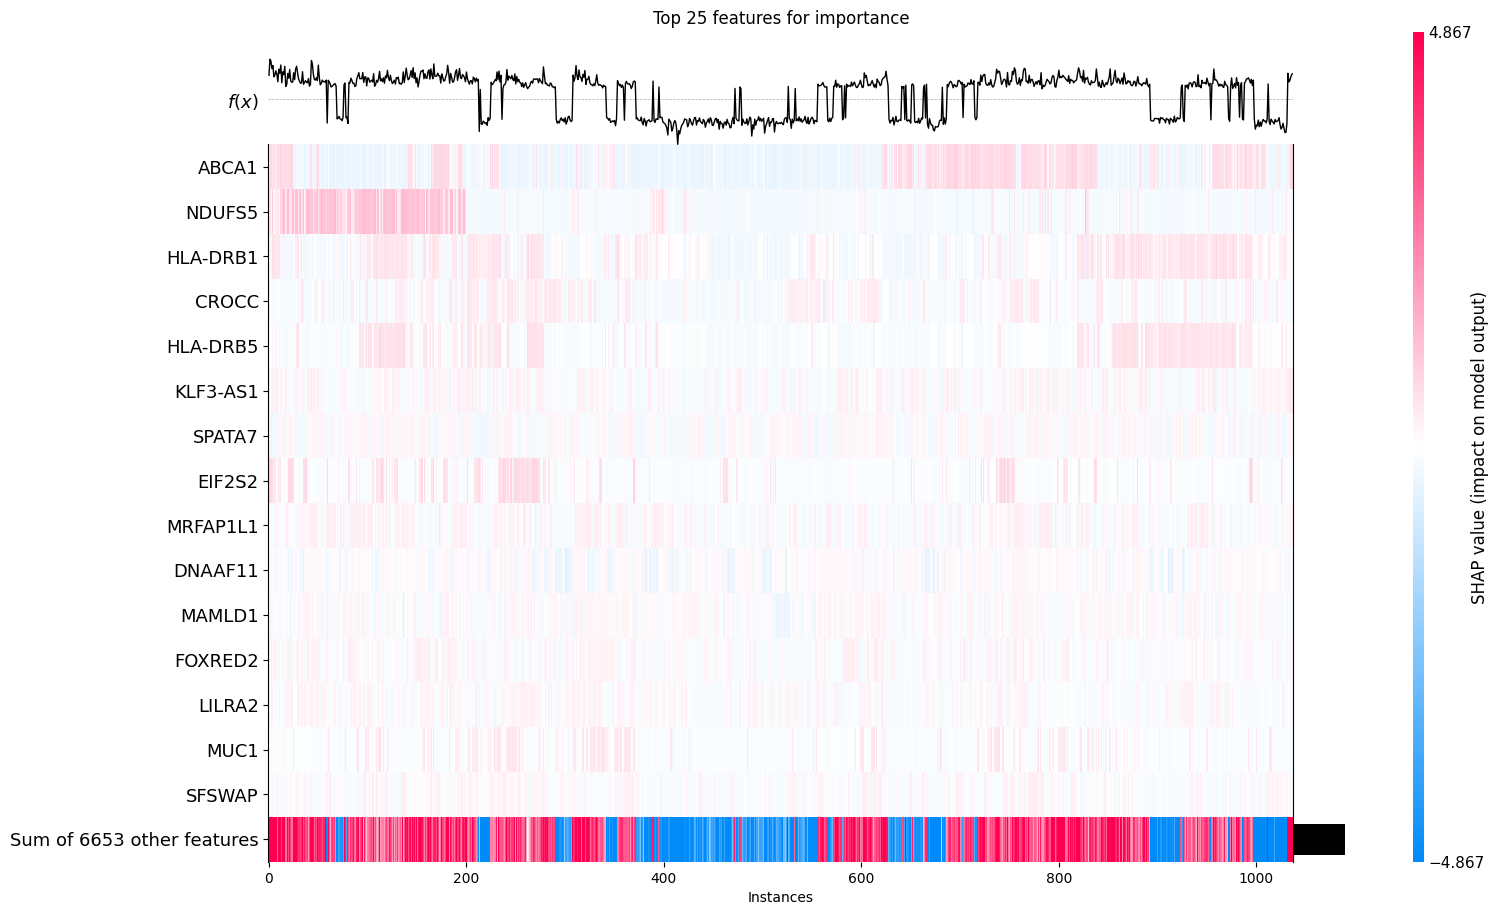

In [51]:
plt.close()
fig, ax = plt.subplots()
shap.plots.heatmap(shap_object, max_display=16, show=False, plot_width=20)
fig.subplots_adjust(left=0.3, top=0.9)
plt.title('Top 15 features for importance')
plt.show()

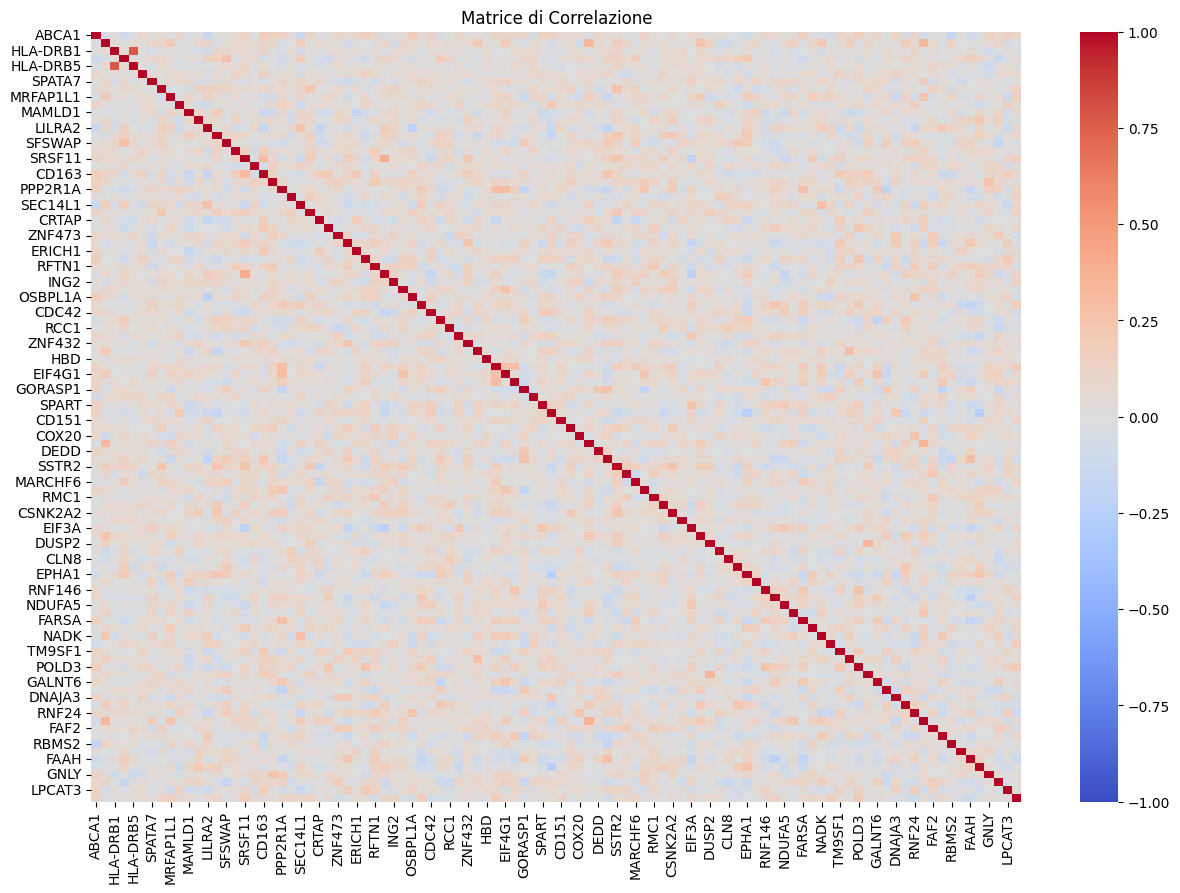

In [ ]:
shapCorr = pd.DataFrame(shap_object.values, columns=dataset.columns)[list(expl_sorted.keys())[:100]].corr()

plt.figure(figsize=(15,10))
sns.heatmap(shapCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

<h3>Insert ex clusters</h3>

In [5]:
clusters = joblib.load("uniqueClustersFull.pkl")
clusters

{('DDX3Y', 'EIF1AY', 'RPS4Y1', 'TXLNGY', 'UTY', 'PRKY'): 'EIF1AY'}

In [7]:
clusterEnriched = addGeneClusters(expl_sorted, clusters)
feature_nonZeroEnriched = addGeneClusters(feature_nonZero, clusters)

print(len(feature_nonZero), "-->", len(feature_nonZeroEnriched))

724 --> 724


<h3>SHAP vs DEA graph</h3>

In [47]:
dea_genes = joblib.load("deaGenesFull.pkl")
sorted_dea_genes = dict(sorted(dea_genes.items(), key=lambda item: item[1]))
print(len(dea_genes.keys()), list(dea_genes.keys()))

1229 ['CLSTN1', 'OSBP', 'EHMT1', 'BPI', 'EMC2', 'HBD', 'AP3B1', 'ATP6V0B', 'OSBPL10', 'C2orf42', 'NECTIN2', 'BLVRA', 'IL15', 'GCLC', 'CD248', 'MRPL22', 'ZNF580', 'YARS2', 'EMC10', 'PTBP1', 'PPP2R5D', 'S100A12', 'RBM26', 'PCID2', 'C14orf93', 'PSMB3', 'NUP98', 'STX10', 'MED17', 'HEATR6', 'TSPAN13', 'DCTN3', 'UPF3B', 'MEF2D', 'ATP5MG', 'POLR2K', 'SWAP70', 'BTRC', 'FASLG', 'PBRM1', 'POFUT2', 'CMKLR1', 'CRTAM', 'CDC5L', 'PLGRKT', 'ARHGEF18', 'UEVLD', 'DGKA', 'RNGTT', 'GORASP1', 'NPC1', 'IP6K2', 'ITGB2', 'HEBP1', 'ZNF254', 'ALDH8A1', 'POLDIP3', 'SASH1', 'WBP4', 'IL16', 'SPARC', 'CTSG', 'PIK3R5', 'USP7', 'NDUFA8', 'NSMCE4A', 'UBE2E1', 'FAAH', 'ADGRE5', 'GTF3C1', 'NR1D2', 'GSDMD', 'CSF1R', 'DENND5A', 'CAPN5', 'UAP1L1', 'MS4A1', 'ZNF224', 'SLBP', 'NQO2', 'USP11', 'EAF2', 'NPFF', 'KCNK12', 'GTF2A2', 'ZNF706', 'H2AC8', 'SUPT16H', 'SPATS2L', 'VCL', 'TBC1D5', 'CXCR4', 'DIDO1', 'RFX1', 'TOMM22', 'USPL1', 'GTF3C2', 'UBE2N', 'RFWD3', 'RAB11FIP2', 'SF3B5', 'NREP', 'NDUFB8', 'OPLAH', 'CRTAP', 'VNN2', 'I

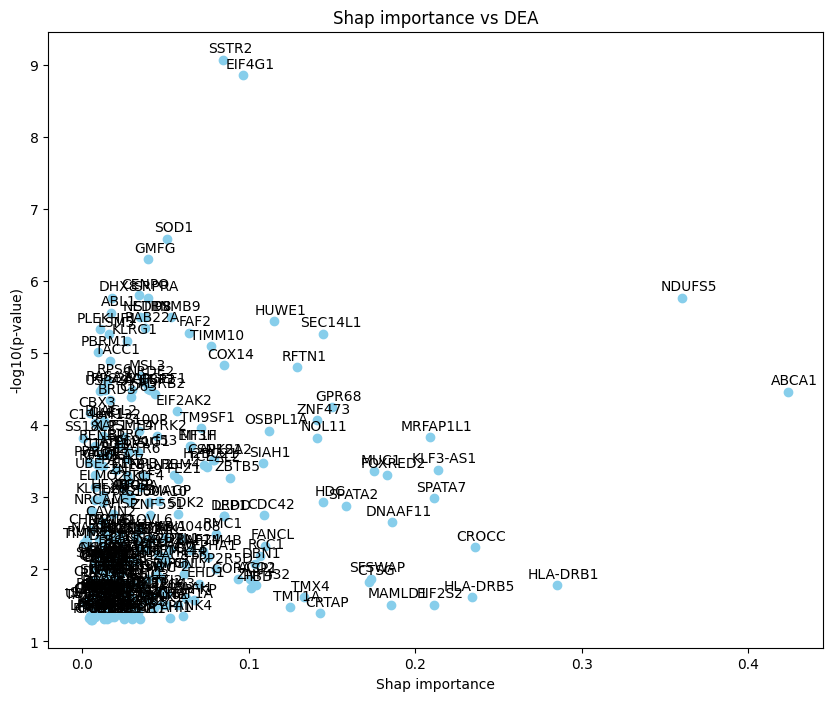

In [50]:
point_x = []
point_y = []

for gene, value in clusterEnriched.items():
    if value > 0 and gene in dea_genes.keys():
        point_x.append(clusterEnriched[gene])
        point_y.append(-np.log10(dea_genes[gene]))

plt.figure(figsize=(10, 8))
plt.scatter(point_x, point_y, color='skyblue')

nonZero = [k for k, v in clusterEnriched.items() if v > 0]

i = 0
for gene, value in clusterEnriched.items():
    if value > 0 and gene in dea_genes.keys():
        plt.annotate(gene, (point_x[i], point_y[i]), textcoords="offset points", xytext=(5,5), ha='center')
        i += 1

plt.xlabel('Shap importance')
plt.ylabel('-log10(p-value)')
plt.title('Shap importance vs DEA')
plt.show()

<h3>Venn diagram SHAP and DEA</h3>

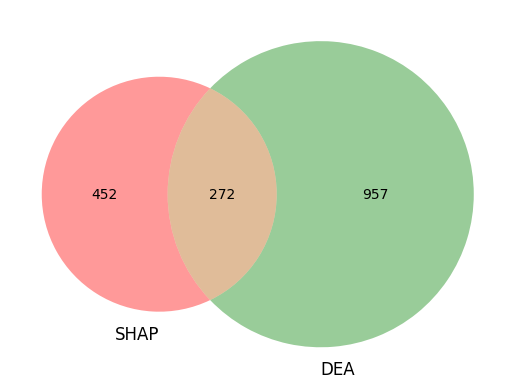

In [52]:
venn2(subsets = [set(feature_nonZeroEnriched), set(dea_genes.keys())], set_labels = ('SHAP', 'DEA'))
plt.show()

Feature important for SHAP not detected by DEA

In [53]:
print(len(set.difference(set(feature_nonZeroEnriched), set(dea_genes.keys()))), set.difference(set(feature_nonZeroEnriched), set(dea_genes.keys())))

452 {'PDK1', 'MAP3K5', 'BTD', 'PPFIBP2', 'NECTIN1', 'PFKFB4', 'SLC7A7', 'RUBCNL', 'JADE2', 'PRR4', 'B3GALT2', 'MARCHF6', 'CD28', 'PCDHAC2', 'PDCL', 'ETV6', 'ADAT1', 'TAF12', 'ANKRD26', 'SPART', 'ZNF230', 'AMBRA1', 'CAB39L', 'NUCB2', 'CUL4B', 'SIK1', 'NAGLU', 'ASB8', 'UNC93B1', 'MYOM1', 'VRK3', 'CEACAM1', 'TAF1', 'ARSB', 'ZC3HAV1', 'DPY19L4', 'HSPA5', 'ALCAM', 'MTX2', 'FUZ', 'SEMA4D', 'RBM39', 'GLUL', 'SF3B1', 'BCAS4', 'GALNT6', 'STAG2', 'EDAR', 'ACTB', 'DENND4C', 'NDUFV1', 'ENTR1', 'RRP7A', 'PRR3', 'SLC4A8', 'OAS2', 'MELK', 'NAMPT', 'PEX6', 'P4HA1', 'EVL', 'ELOVL1', 'SASH3', 'COL5A1', 'TXNRD1', 'IL1B', 'POLM', 'ARHGAP4', 'IL2RA', 'GCNT2', 'DARS2', 'TWSG1', 'MRPL35', 'MGST3', 'CLEC2D', 'HLCS', 'MORN3', 'ZNF3', 'NEDD4L', 'DPYSL4', 'RPL41', 'CD1E', 'PTPN6', 'KHNYN', 'MRE11', 'CYP27A1', 'UPK3A', 'CCND1', 'OXCT1', 'PREPL', 'SLC33A1', 'ENO1', 'PARM1', 'NKTR', 'CD163', 'ABITRAM', 'PPP3R1', 'OSM', 'SKI', 'NFKBIA', 'TAF15', 'YEATS4', 'DDX56', 'MAST2', 'IK', 'ANP32CP', 'C1orf56', 'CLIP4', 'ME1',

Best 300 SHAP features compared with DEA

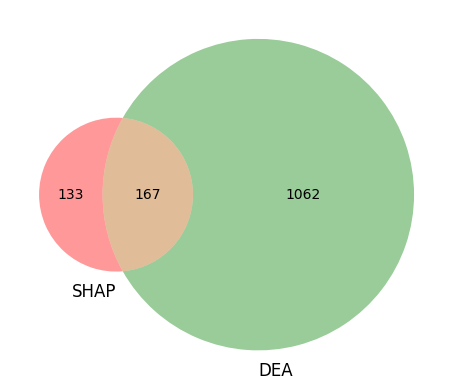

In [58]:
venn2(subsets = [set(list(feature_nonZeroEnriched.keys())[:300]), set(dea_genes.keys())], set_labels = ('SHAP', 'DEA'))
plt.show()

Known feature important for MS

In [59]:
limit = None

feature_nonZeroList = list(feature_nonZero.keys())[:limit]

for gene in ["GABPA", "CTCF", "EGR1", "YY1", "SPI1", "CLOCK", "ARNTL", "BACH1", "GFI1", "IFNB1", "MOG",  "MBP", "CD42", "IFNG", "IL17A", "IL10", "TNF", "IL1B", "IL6", "TNFRSF1A", "CYP27B1", "IL7R", "HLA-DRB1", "HLA-DRB5", "IL2RA"]:
    if gene in dataset.columns:
        if gene in feature_nonZeroList[:limit] and gene in list(sorted_dea_genes.keys())[:limit]:
            print(gene, "Both")
        elif gene in feature_nonZeroList[:limit]:
            print(gene, "SHAP")
        elif gene in list(sorted_dea_genes.keys())[:limit]:
            print(gene, "DEA")
        else:
            print(gene, "None")
    else:
        print(gene, "Not in dataset")

GABPA DEA
CTCF Not in dataset
EGR1 SHAP
YY1 None
SPI1 None
CLOCK None
ARNTL Not in dataset
BACH1 None
GFI1 DEA
IFNB1 Not in dataset
MOG Not in dataset
MBP DEA
CD42 Not in dataset
IFNG Not in dataset
IL17A Not in dataset
IL10 Not in dataset
TNF None
IL1B SHAP
IL6 Not in dataset
TNFRSF1A None
CYP27B1 Not in dataset
IL7R Not in dataset
HLA-DRB1 Both
HLA-DRB5 Both
IL2RA SHAP


<h2>xxAI Analysis</h2>

In [61]:
color = ['red', 'navy', 'grey', 'yellow', 'green', 'purple', 'pink', 'brown']
classiDataset = ['GSE41848', 'GSE41849', 'GSE146383', 'GSE13732', 'GSE136411', 'GSE17048', 'GSE41890', 'GSE21942']
classiLabel = ['Control', 'MS']
colorLabel = ['Black', 'Orange']
classiGender = ['Female', 'Male']
colorGender = ['Red', 'Blue']

dataset = pd.read_csv('../../Dataset/MergedDatasetFullCombatDeclustered_symbol.csv')
dataset['Gender'] = joblib.load("genderFull.pkl")
dataset

SampleID      PatientID  Label     TRAK2  \
0                0-GSM1026056_600009.0001  0-600009.0001      1  9.597071   
1     0-GSM1026057_600009.0001-FollowUp_1  0-600009.0001      1  9.039251   
2                 0-GSM1026058_41461.0001   0-41461.0001      1  8.791386   
3                 0-GSM1026059_41462.0001   0-41462.0001      1  9.373170   
4                0-GSM1026060_600029.0001  0-600029.0001      1  9.076237   
...                                   ...            ...    ...       ...   
1033                      7-GSM545842_M10          7-M10      1  8.955028   
1034                      7-GSM545843_M11          7-M11      1  9.101329   
1035           7-GSM545844_M11-FollowUp_1          7-M11      1  9.271382   
1036                      7-GSM545845_M12          7-M12      1  9.351712   
1037           7-GSM545846_M12-FollowUp_1          7-M12      1  9.292476   

       MARCHF5      AVIL    CLSTN1    TAPBPL     TRIM38     GDF11  ...  \
0     6.172613  6.183003  7.619254  8.451946   9.674435  6.629841  ...   
1     6.532620  6.350718  7.841904  8.629886   9.565077  6.824635  ...   
2     6.548371  6.933703  7.279164  8.166420   9.772884  6.515736  ...   
3     7.116801  7.012218  7.233344  8.338171   9.725869  6.458866  ...   
4     7.104757  6.515409  7.488312  8.355218  10.033820  6.189225  ...   
...        ...       ...       ...       ...        ...       ...  ...   
1033  6.642111  6.639887  7.445428  8.359939   9.682368  6.735513  ...   
1034  6.715089  6.611748  7.449074  8.112262   9.634445  6.503292  ...   
1035  6.670915  6.620238  7.404586  8.119619   9.650254  6.681918  ...   
1036  6.679360  6.581669  7.442222  8.282929   9.638524  6.409742  ...   
1037  6.678637  6.662260  7.397570  8.343229   9.653412  6.024943  ...   

         NDUFA1      PEX7      NET1     TMED5      FADD     URGCP      MDM4  \
0     10.188925  6.535162  7.816546  9.744325  8.263995  7.352167  8.662674   
1     10.255465  6.432247  7.916046  9.687447  8.241698  7.349809  8.445578   
2     10.101372  6.495679  8.104559  9.632676  8.242744  7.205897  8.071700   
3     10.314306  6.353293  7.386301  9.769748  8.376067  7.312015  8.425182   
4     10.243407  6.334131  7.331289  9.626407  8.217957  7.254979  7.917974   
...         ...       ...       ...       ...       ...       ...       ...   
1033  10.312671  5.698647  7.380776  9.698418  8.155223  7.361099  8.327890   
1034  10.357670  6.671623  7.428976  9.763741  8.122246  7.262578  8.175908   
1035  10.208762  6.715863  7.705067  9.785031  8.103883  7.362873  8.131763   
1036  10.401224  6.861365  7.413546  9.703183  8.135620  7.244212  8.187447   
1037  10.255236  6.813299  7.595989  9.750070  8.454906  7.257439  8.178654   

        BMPR1A    EIF1AY  Gender  
0     6.263145  5.084750  Female  
1     7.242537  5.046855  Female  
2     6.124447  5.049761  Female  
3     6.534315  5.051708  Female  
4     6.195773  5.038392  Female  
...        ...       ...     ...  
1033  6.361955  5.504788  Female  
1034  7.282642  5.622606  Female  
1035  7.425195  5.609163  Female  
1036  6.908857  5.568584  Female  
1037  6.913615  5.572668  Female  

[1038 rows x 6672 columns]

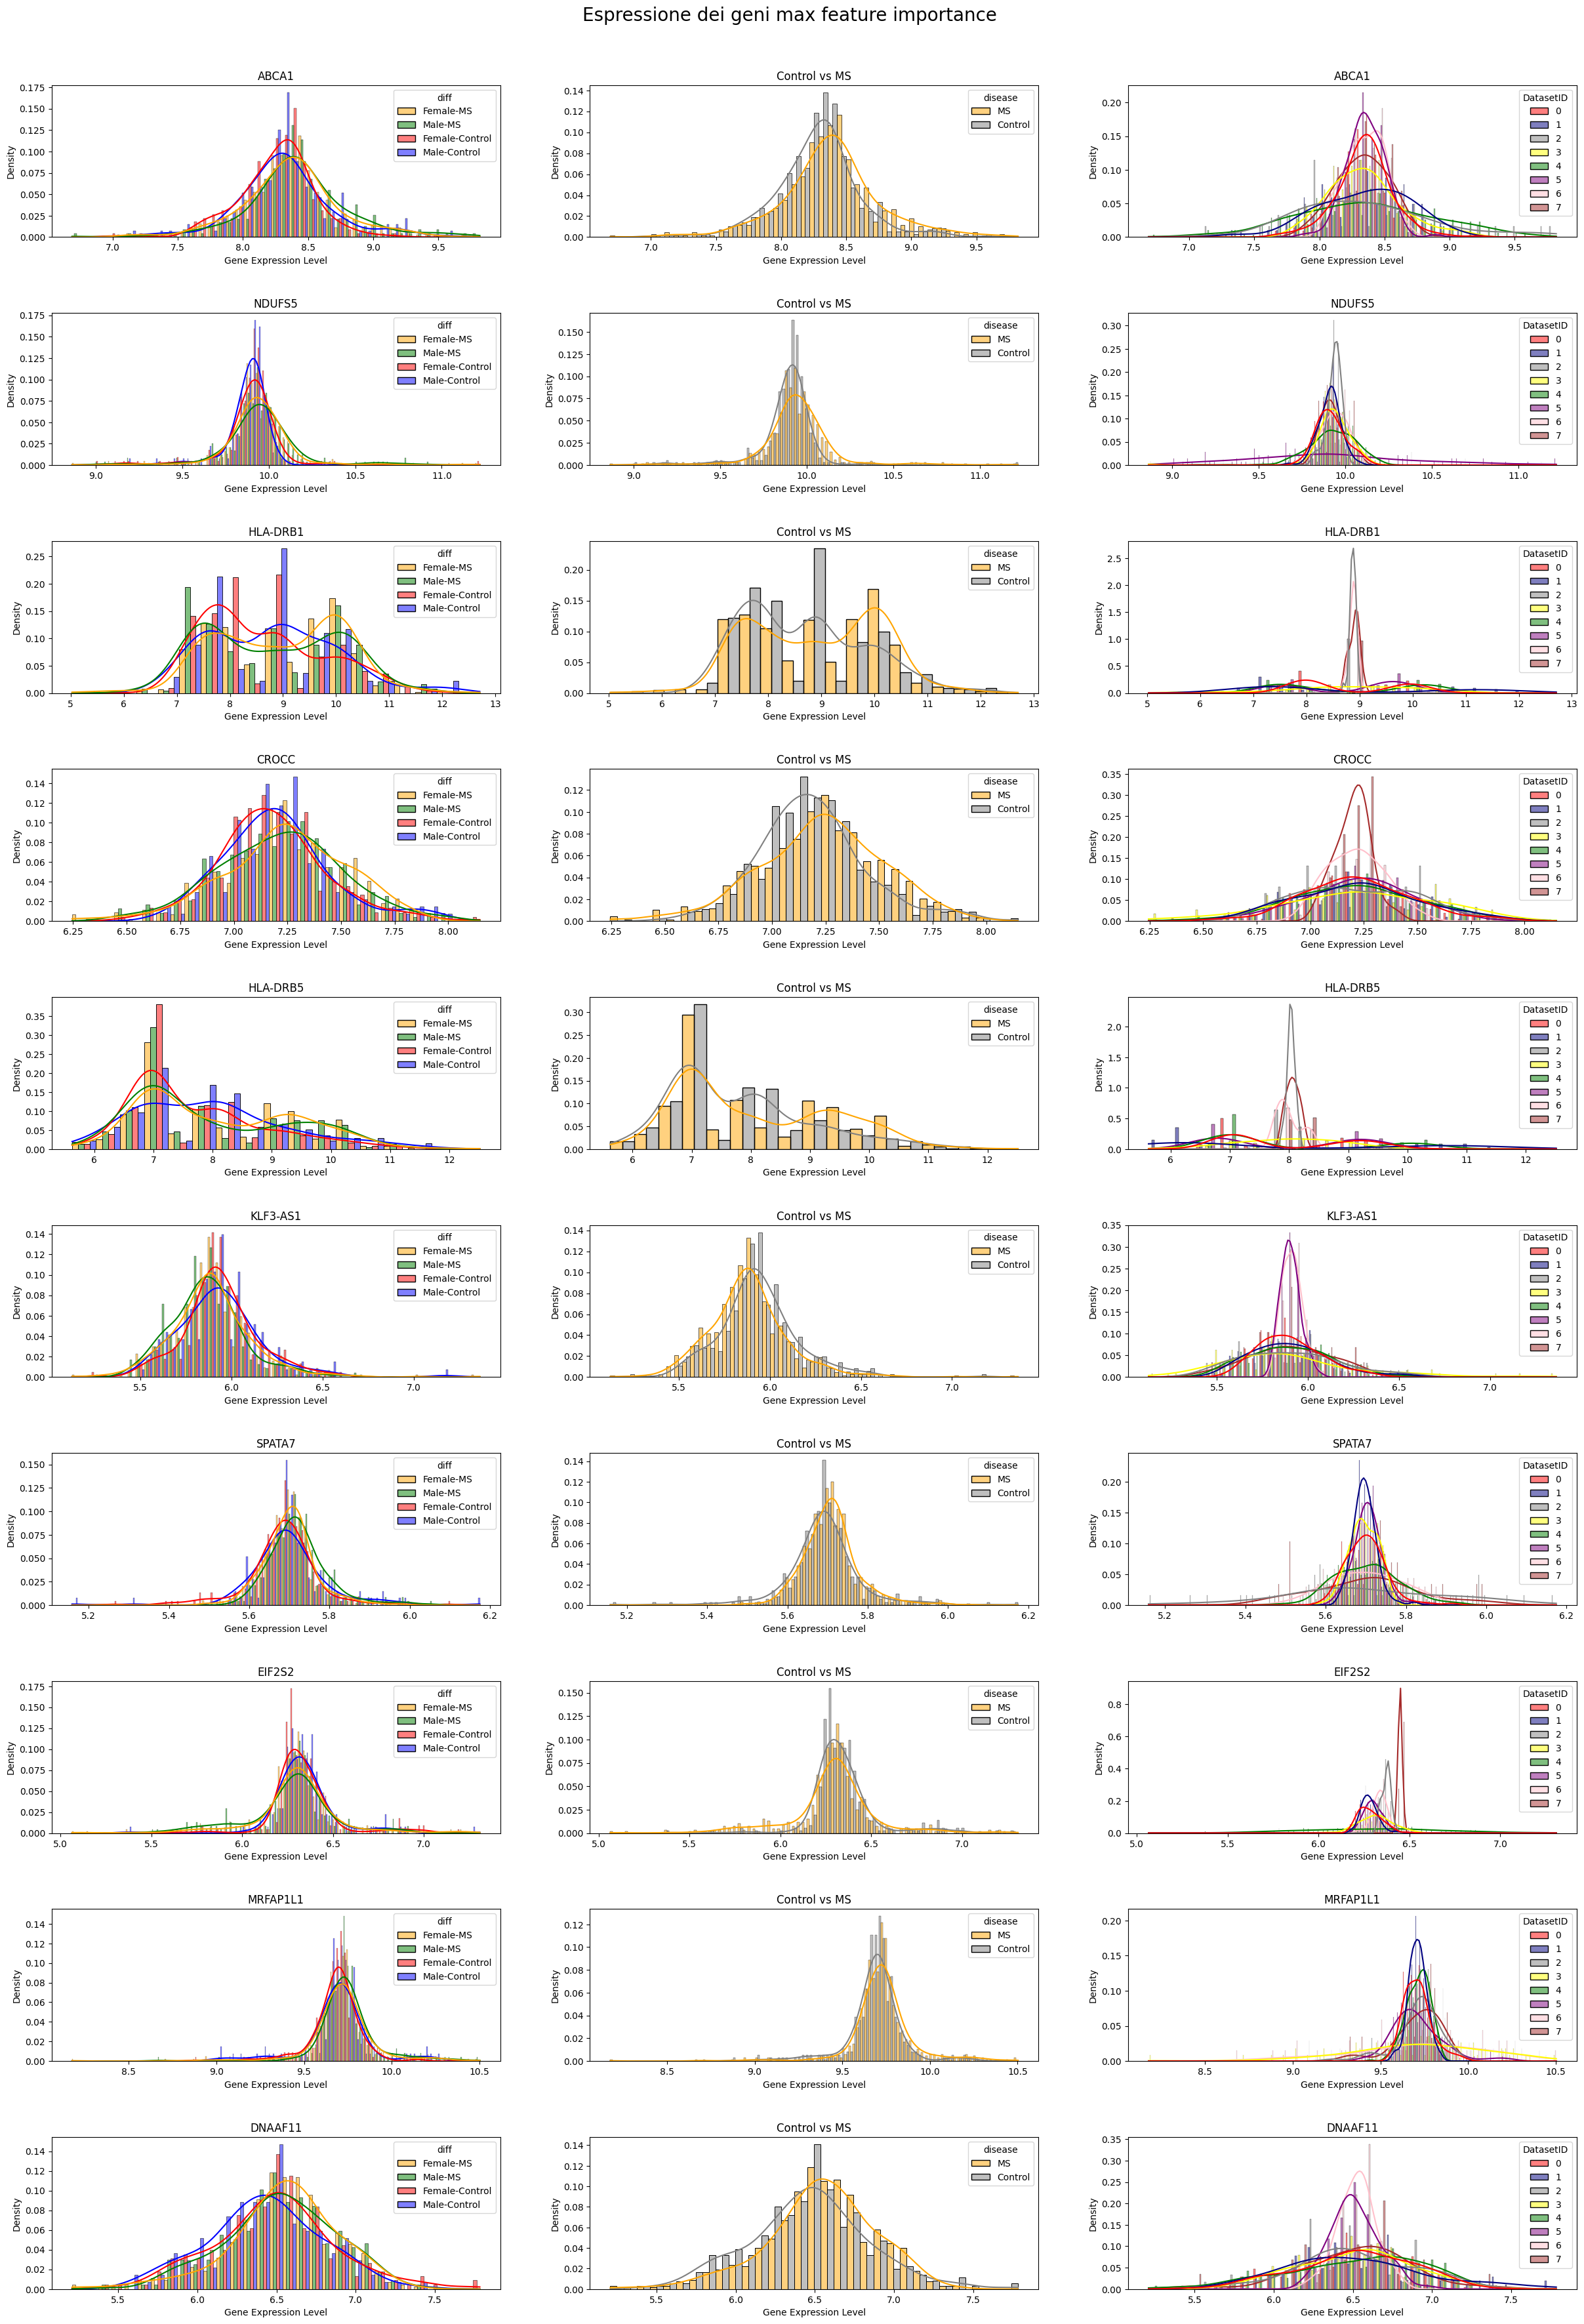

In [62]:
current = dataset.copy()

warnings.filterwarnings("ignore")

current['disease'] = current['Label'].apply(lambda x: 'MS' if x == 1 else 'Control')
current['diff'] = current['Gender']+"-"+current['disease'].astype(str)
current['DatasetID'] = current['SampleID'].apply(lambda x: x.split("-")[0])

gene_list = list(feature_nonZero.keys())[:10]

fig, axes = plt.subplots(len(gene_list), 3, figsize=(30, 40))

for i, gene in enumerate(gene_list):
    sns.histplot(data=current, x=gene, hue='diff', stat="probability",
                 kde=True, palette={'Female-MS':'orange', 'Female-Control':'red', 'Male-MS':'green', 'Male-Control':'blue'}, multiple='dodge', common_norm=False, ax=axes[i][0])
    axes[i][0].set_title(gene)
    axes[i][0].set_xlabel("Gene Expression Level")
    axes[i][0].set_ylabel("Density")


    sns.histplot(data=current, x=gene, hue='disease', stat="probability",
                 kde=True, palette={'Control': 'grey', 'MS': 'orange'}, multiple='dodge', common_norm=False, ax=axes[i][1])
    axes[i][1].set_title('Control vs MS')
    axes[i][1].set_xlabel("Gene Expression Level")
    axes[i][1].set_ylabel("Density")

    sns.histplot(data=current, x=gene, hue='DatasetID', stat="probability",
                 kde=True, palette={'0':'red', '1':'navy', '2':'grey', '3':'yellow', '4':'green', '5':'purple', '6':'pink', '7':'brown'}, multiple='dodge', common_norm=False, ax=axes[i][2])
    axes[i][2].set_title(gene)
    axes[i][2].set_xlabel("Gene Expression Level")
    axes[i][2].set_ylabel("Density")

    plt.subplots_adjust(hspace=0.5)

plt.suptitle("Espressione dei geni max feature importance", fontsize=20)
plt.subplots_adjust(top=0.95)
plt.show()